# Empfehlungs-System basierend auf dem Yelp-Datensatz

Dieses Notebook ist vom Notebook Yelp_ALS_Spark.ipynb abgeleitet. Alle Kommentare und Erläuterungen wurden hier entfernt. Bei Fragen zur Funktion der einzelnen Abschnitte ist der Leser auf das genannte Notebook verwiesen.

## Module importieren und Spark initialisieren

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import json
import numpy as np
import pandas as pd
import time
import itertools
import os
import requests
import subprocess
from functools import partial

import types as python_types
import pyspark
from pyspark.sql import functions as F, types, SparkSession
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pylab as plt
import seaborn as sns
plt.style.use("seaborn-ticks")
sns.set_style("ticks")
%matplotlib inline

start_time = time.time()

In [3]:
sc = pyspark.SparkContext("local[*]")
sqlc = pyspark.SQLContext(sc)

In [4]:
%aimport utils

## Daten runterladen und extrahieren

In [5]:
if not os.path.exists("data/ml-1m/ratings.dat"):
    r = requests.get("http://files.grouplens.org/datasets/movielens/ml-1m.zip")
    with open("data/ml-1m.zip", "wb") as f:
        f.write(r.content)
    subprocess.run(["unzip", "-d", "data/", "data/ml-1m.zip"])

## Daten einlesen

In [6]:
lines = sc.textFile("data/ml-1m/ratings.dat")
rows = lines.map(lambda line: tuple(map(int, line.split("::"))))
review_df = sqlc.createDataFrame(
    rows, ["user", "item", "rating", "timestamp"])
review_df = review_df.select(
    (F.col("user")-1).cast(types.IntegerType()).alias("user"),
    (F.col("item")-1).cast(types.IntegerType()).alias("item"), 
    F.col("rating").cast(types.FloatType()),
    F.from_unixtime("timestamp").alias("date")
)
review_df.cache()

DataFrame[user: int, item: int, rating: float, date: string]

## Einige Übersichts-Statistiken

### Anzahl der Bewertungen

In [7]:
review_df.count()

1000209

### Anzahl der User und Items (Nutzer und Geschäfte)

In [8]:
review_df.agg(F.countDistinct("user"), F.countDistinct("item"), F.countDistinct("rating")).show()

+--------------------+--------------------+----------------------+
|count(DISTINCT user)|count(DISTINCT item)|count(DISTINCT rating)|
+--------------------+--------------------+----------------------+
|                6040|                3706|                     5|
+--------------------+--------------------+----------------------+



### Verteilung der Werte der Bewertungen

Die Wertebereich der Bewertungen ist 1 bis 5 Sterne. Man sieht, dass die Verteilung zu hohen Werten verschoben ist.

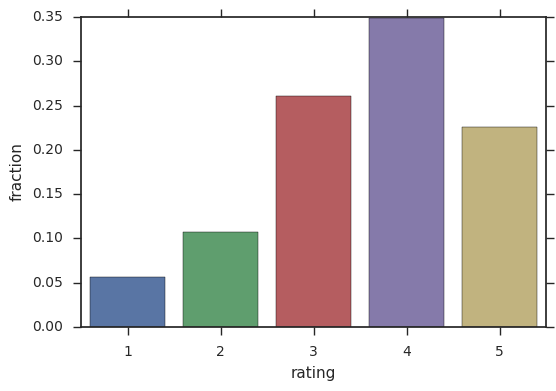

In [9]:
bins, counts = (review_df
                .select("rating")
                .rdd.keys()
                .histogram([1,2,3,4,5,6]))

utils.plot_histogram(bins, counts, xlabel="rating")
plt.savefig("plots/movielens_rating_histogram.pdf", bbox_inches="tight")

### Wie viele Bewertungen haben einzelne Items?

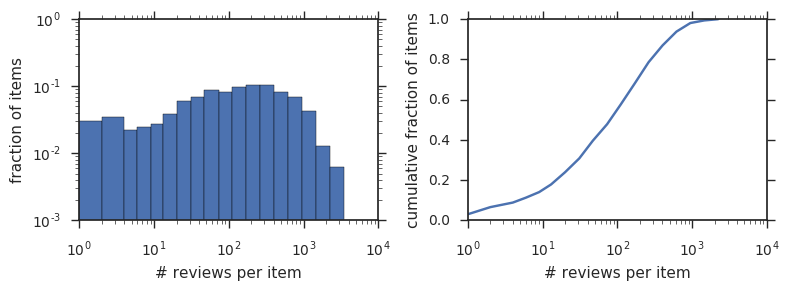

In [10]:
_ = utils.count_reviews(review_df, "item")
plt.savefig("plots/movielens_number_reviews_items.pdf", bbox_inches="tight")

### Wie viele Bewertungen haben einzelne User?

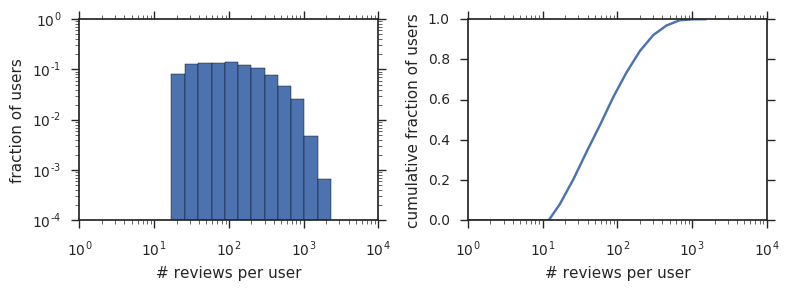

In [11]:
_ = utils.count_reviews(review_df, "user")
plt.savefig("plots/movielens_number_reviews_users.pdf", bbox_inches="tight")

### Verteilung der Bewertungen nach Datum

In [12]:
review_df.agg(F.min("date"), F.max("date")).show()

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2000-04-25 23:05:32|2003-02-28 17:49:50|
+-------------------+-------------------+



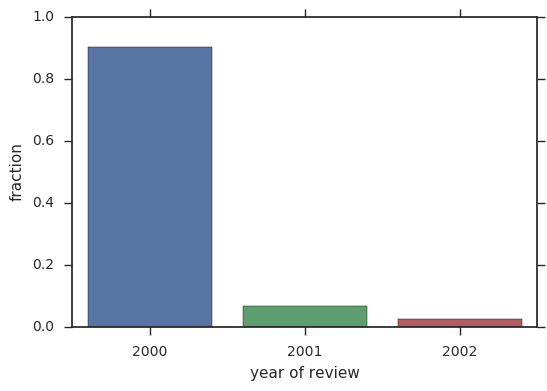

In [13]:
def get_year(s):
    return int(s[:4])

bins, counts = (review_df
                .select("date")
                .rdd.keys()
                .map(get_year)
                .histogram(list(range(2000, 2004))))

utils.plot_histogram(bins, counts, xlabel="year of review")
plt.savefig("plots/movielens_number_reviews_year.pdf", bbox_inches="tight")

## Datensatz auf Objekte mit eine Mindestanzahl von Bewertungen einschränken

In [14]:
restrict = True
min_user_reviews = 10
min_item_reviews = 20

In [15]:
if restrict:
    reviews_per_user = review_df.groupBy("user").agg(F.count("rating").alias("user_reviews"))
    reviews_per_item = review_df.groupBy("item").agg(F.count("rating").alias("item_reviews"))
    
    review_df = (review_df
             .join(reviews_per_user, review_df["user"]==reviews_per_user["user"])
             .join(reviews_per_item, review_df["item"]==reviews_per_item["item"])
             .filter((F.col("user_reviews") >= min_user_reviews) & (F.col("item_reviews") >= min_item_reviews))
             .select(review_df["user"], review_df["item"], "rating", "date")
         )
    
    review_df.cache()

In [16]:
review_df.count()

995492

In [17]:
review_df.agg(F.countDistinct("user"), F.countDistinct("item"), F.countDistinct("rating")).show()

+--------------------+--------------------+----------------------+
|count(DISTINCT user)|count(DISTINCT item)|count(DISTINCT rating)|
+--------------------+--------------------+----------------------+
|                6040|                3043|                     5|
+--------------------+--------------------+----------------------+



## Training-Test-Split für Kreuzvalidierung

In [18]:
train, test = review_df.randomSplit([0.75,0.25], seed=42)
train.cache()
test.cache()

DataFrame[user: int, item: int, rating: float, date: string]

In [19]:
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")

## Trivialer Prädiktor

In [20]:
average_rating = train.agg(F.mean("rating")).first()[0]
average_rating

3.583727381290264

In [21]:
rmse.evaluate(test.withColumn("prediction", F.lit(average_rating)))

1.1151348345776522

## Collaborative Filtering mit Matrix-Faktorisierung

### Parameterscan und Hilfsfunktionen

In [22]:
def fillna(df, val, col="prediction"):
    return df.fillna(val, col)

fillna_mean = partial(fillna, val=average_rating)
fillna_zero = partial(fillna, val=0.0)

restrict_range = F.udf(lambda r: min(max(r,1.),5.), types.FloatType())

def restrict_output(df, col="prediction"):
    return df.withColumn(col, restrict_range(col))

In [23]:
def parameter_scan(estimator_factory, parameters, pre=(), post=(), save=None, load=False,
                   test=test, train=train):
    if load and save and os.path.exists(save):
        scores = pd.read_pickle(save)
        return scores
    
    scores = []
    
    train_ = train
    for p in pre:
        train_ = p(train_)
    
    for param_set in itertools.product(*parameters.values()):
        param_set = dict(zip(parameters.keys(), param_set))
        estimator = estimator_factory(**param_set)
        
        model = estimator.fit(train_)
        pred_train = model.transform(train)
        pred_test = model.transform(test)
                
        for p in post:
            pred_train = p(pred_train)
            pred_test = p(pred_test)

        rmse_train = rmse.evaluate(pred_train)
        rmse_test = rmse.evaluate(pred_test)
        
        score = param_set
        score["rmse_train"] = rmse_train
        score["rmse_test"] = rmse_test
        scores.append(score)
        
    scores = pd.DataFrame(scores)
    
    if save:
        scores.to_pickle(save)
        
    return scores

## Meta-Parameter Optimierung des ALS

### Abhängigkeit von maxIter

In [24]:
%%time
parameters = dict(maxIter=[5,10,20,30], regParam=[0.1], rank=[10])
postprocessing = [fillna_mean, restrict_output]
scores = parameter_scan(ALS, parameters, post=postprocessing, 
                        save="cv_maxiter.pkl")

CPU times: user 332 ms, sys: 132 ms, total: 464 ms
Wall time: 2min 53s


In [25]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,5,10,0.1,0.878672,0.830653
1,10,10,0.1,0.866174,0.814229
2,20,10,0.1,0.860696,0.807774
3,30,10,0.1,0.859556,0.806356


### Abhängigkeit von regParam und rank

In [26]:
%%time
parameters = dict(regParam=[0.025, 0.05, 0.1, 0.25], 
                  rank=[5, 10, 20],
                  maxIter=[20])
postprocessing = [fillna_mean, restrict_output]
scores = parameter_scan(ALS, parameters, post=postprocessing,
                        save="cv_reg_rank.pkl")

CPU times: user 852 ms, sys: 416 ms, total: 1.27 s
Wall time: 8min 32s


In [27]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.025,0.865374,0.807816
1,20,10,0.025,0.865719,0.748389
2,20,20,0.025,0.889738,0.667517
3,20,5,0.050,0.863707,0.814929
4,20,10,0.050,0.854340,0.764180
5,20,20,0.050,0.859902,0.702760
6,20,5,0.100,0.870612,0.835700
7,20,10,0.100,0.860696,0.807774
8,20,20,0.100,0.859810,0.787768
9,20,5,0.250,0.934574,0.922153


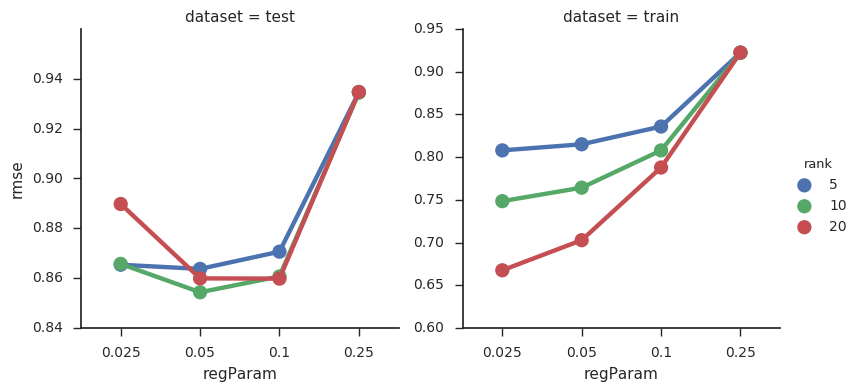

In [28]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="regParam", y="rmse", 
               hue="rank", col="dataset", col_order=["test", "train"])
plt.savefig("plots/movielens_scan_reg_rank_plain_als.pdf", bbox_inches="tight")

## Daten um den Mittelwert bereinigen und an die Residuen fitten

In [29]:
def subtract_mean(df, mean=average_rating, col="rating"):
    return df.withColumn(col, F.col(col) - mean)

def add_mean(df, mean=average_rating, col="prediction"):
    return df.withColumn(col, F.col(col) + mean)

In [30]:
%%time
parameters = dict(regParam=[0.025, 0.05, 0.1, 0.25], 
                  rank=[5, 10, 20],
                  maxIter=[20])
preprocessing = [subtract_mean]
postprocessing = [fillna_zero, add_mean, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing,
                        save="cv_reg_rank_residual.pkl")

CPU times: user 908 ms, sys: 352 ms, total: 1.26 s
Wall time: 8min 19s


In [31]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.025,0.865012,0.807944
1,20,10,0.025,0.869371,0.749907
2,20,20,0.025,0.896336,0.670214
3,20,5,0.050,0.864719,0.815948
4,20,10,0.050,0.859444,0.767168
5,20,20,0.050,0.867195,0.705946
6,20,5,0.100,0.876118,0.841121
7,20,10,0.100,0.869840,0.816566
8,20,20,0.100,0.867896,0.794735
9,20,5,0.250,0.951156,0.941052


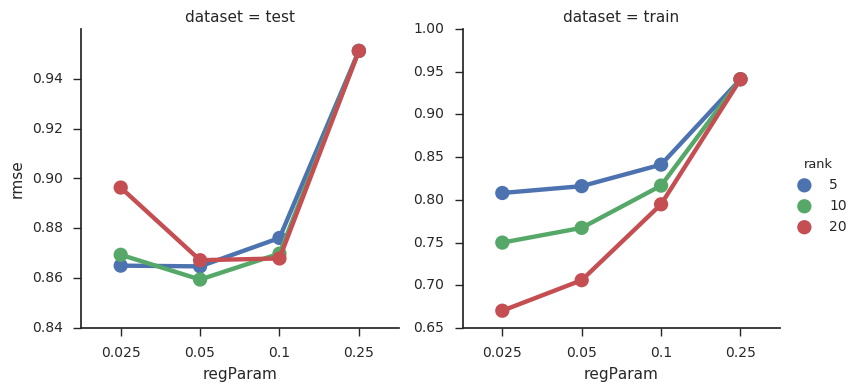

In [32]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="regParam", y="rmse", 
               hue="rank", col="dataset", col_order=["test", "train"])
plt.savefig("plots/movielens_scan_reg_rank_mu_als.pdf", bbox_inches="tight")

### User- und Itembias Vektoren

In [33]:
user_bias = train.groupBy("user").agg((F.mean("rating") - average_rating).alias("user_bias"))
user_bias.cache()
item_bias = train.groupBy("item").agg((F.mean("rating") - average_rating).alias("item_bias"))
item_bias.cache()
user_bias.show(5)

+----+-------------------+
|user|          user_bias|
+----+-------------------+
| 148| 0.3984948409319582|
| 463|-0.0755306599787886|
|1088|0.45263625507337224|
|1238|0.28951205532945457|
|1591|0.02153577660447281|
+----+-------------------+
only showing top 5 rows



In [34]:
test_pred = (test
 .join(user_bias, "user", how="left")
 .join(item_bias, "item", how="left")
 .na.fill(0.0, ["user_bias", "item_bias"])
 .select("user", "item", "rating", 
         (F.lit(average_rating) + F.col("user_bias") + F.col("item_bias")).alias("prediction"))
    )

In [35]:
rmse.evaluate(test_pred)

0.9342364918974136

##### Einschränken des Output-Wertebereiches bringt Verbesserung

In [36]:
rmse.evaluate(restrict_output(test_pred))

0.9331458111852411

### Daten um Mittelwert und Bias-Vektoren bereinigen

In [37]:
def subtract_mean_and_biases(df, user_bias=user_bias, item_bias=item_bias, 
                             mean=average_rating, col="rating"):
    df = (df
          .join(user_bias, "user", how="left")
          .join(item_bias, "item", how="left")
          .withColumn(col, F.col(col) - mean - F.col("user_bias") - F.col("item_bias"))
         )
    return df

def add_mean_and_biases(df, user_bias=user_bias, item_bias=item_bias, 
                        mean=average_rating, col="prediction"):
    assert col == "prediction"
    df = (df
          .join(user_bias, "user", how="left")
          .join(item_bias, "item", how="left")
          .na.fill(0.0, ["user_bias", "item_bias", "prediction"])
          .withColumn("prediction", mean + F.col("user_bias") + F.col("item_bias") + F.col("prediction"))
         )
    return df

In [38]:
%%time
parameters = dict(regParam=[0.025, 0.05, 0.1, 0.25], 
                  rank=[5, 10, 20],
                  maxIter=[20])
preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing, 
                        save="cv_reg_rank_residual2.pkl")

CPU times: user 1.05 s, sys: 412 ms, total: 1.46 s
Wall time: 9min 3s


In [39]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.025,0.870266,0.806352
1,20,10,0.025,0.875664,0.749949
2,20,20,0.025,0.901520,0.671546
3,20,5,0.050,0.868560,0.814729
4,20,10,0.050,0.864971,0.767729
5,20,20,0.050,0.871375,0.707659
6,20,5,0.100,0.876862,0.839878
7,20,10,0.100,0.871062,0.816579
8,20,20,0.100,0.869881,0.795964
9,20,5,0.250,0.928516,0.916430


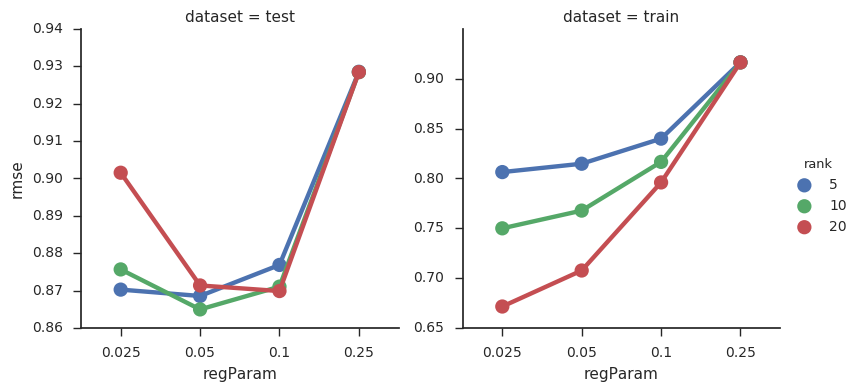

In [40]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="regParam", y="rmse", 
               hue="rank", col="dataset", col_order=["test", "train"])
plt.savefig("plots/movielens_scan_reg_rank_mu_bias_als.pdf", bbox_inches="tight")

### Nochmaliger Scan von maxIter

In [41]:
%%time
parameters = dict(regParam=[0.05], 
                  rank=[10],
                  maxIter=[5,10,20,30])
preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing)

CPU times: user 400 ms, sys: 176 ms, total: 576 ms
Wall time: 3min


In [42]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,5,10,0.05,0.875430,0.780723
1,10,10,0.05,0.867037,0.770549
2,20,10,0.05,0.864971,0.767729
3,30,10,0.05,0.864603,0.767292


## Finaler Test des besten Models

In [43]:
train, test = review_df.randomSplit([0.75,0.25], seed=7)
train.cache()
test.cache()

DataFrame[user: int, item: int, rating: float, date: string]

In [44]:
# average needs to be determined again
average_rating = train.agg(F.mean("rating")).first()[0]
average_rating

3.5843235333102155

In [45]:
# biases need to be determined again
user_bias = train.groupBy("user").agg((F.mean("rating") - average_rating).alias("user_bias"))
user_bias.cache()
item_bias = train.groupBy("item").agg((F.mean("rating") - average_rating).alias("item_bias"))
item_bias.cache()
user_bias.show(5)

+----+-------------------+
|user|          user_bias|
+----+-------------------+
| 148| 0.3258147155377107|
|1088|0.49410783923880386|
|1238| 0.3079841589974768|
|1591|0.08234313335645105|
|1959|0.18442646668978435|
+----+-------------------+
only showing top 5 rows



In [46]:
# insert new average and biases into pre- and post-processing functions
subtract_mean_and_biases = partial(subtract_mean_and_biases, 
                                   user_bias=user_bias, 
                                   item_bias=item_bias, 
                                   mean=average_rating)

add_mean_and_biases = partial(add_mean_and_biases, 
                              user_bias=user_bias, 
                              item_bias=item_bias, 
                              mean=average_rating)

In [47]:
test_pred = (test
 .join(user_bias, "user", how="left")
 .join(item_bias, "item", how="left")
 .na.fill(0.0, ["user_bias", "item_bias"])
 .select("user", "item", "rating", 
         (F.lit(average_rating) + F.col("user_bias") + F.col("item_bias")).alias("prediction"))
    )

rmse.evaluate(restrict_output(test_pred))

0.9286287217781842

In [48]:
# parameter scan with new train-test-split
parameters = dict(regParam=[0.05], rank=[10], maxIter=[20])

preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]

score = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing, 
                       test=test, train=train)
score

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,10,0.05,0.861653,0.768874


## Untersuchung der Fehler der Vorhersagen

In [49]:
# train ALS with optimal parameters
als = ALS(regParam=0.05, rank=10, maxIter=20).fit(subtract_mean_and_biases(train))

In [50]:
pred_als = als.transform(test)

### Verteilung der Korrekturen durch das ALS

In [51]:
bins, counts = (pred_als
                .select("prediction")
                .rdd.keys()
                .histogram(list(np.linspace(-2,2,30))))

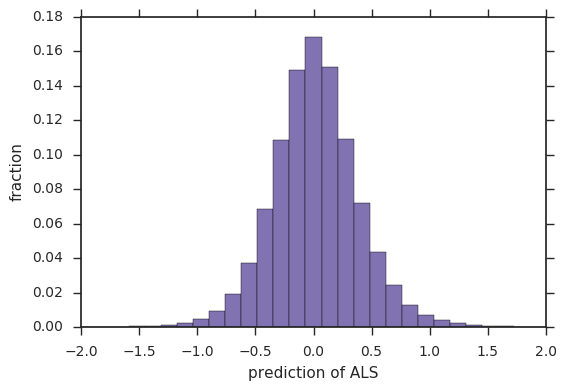

In [52]:
utils.plot_histogram(bins, counts, "prediction of ALS", seaborn=False, color=utils.purple)
plt.savefig("plots/movielens_histogram_als_output.pdf", bbox_inches="tight")

### Verteilung der vorhergesagten und realen Bewertungen

In [53]:
prediction = \
    restrict_output(
        add_mean_and_biases(
            fillna_zero(
                als.transform(test)))).cache()

In [54]:
prediction_bias_only = \
    restrict_output(
        add_mean_and_biases(
            fillna_zero(
                test.withColumn("prediction", F.lit(0))))).cache()

In [55]:
bins = [1,2,3,4,5,6]
bins1, count1 = prediction.select("prediction").rdd.keys().histogram(bins)
bins2, count2 = prediction_bias_only.select("prediction").rdd.keys().histogram(bins)
bins3, count3 = prediction.select("rating").rdd.keys().histogram(bins)

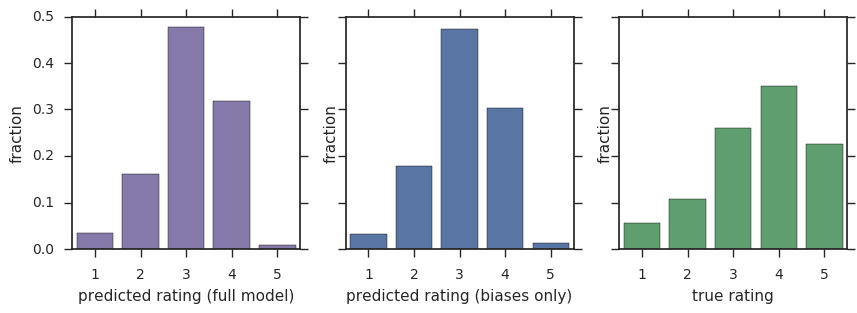

In [56]:
f, axs = plt.subplots(1,3,sharey=True, figsize=(10,3))
plt.sca(axs[0])
utils.plot_histogram(bins1, count1, "predicted rating (full model)", color=utils.purple)
plt.sca(axs[1])
utils.plot_histogram(bins2, count2, "predicted rating (biases only)", color=utils.blue)
plt.sca(axs[2])
utils.plot_histogram(bins3, count3, "true rating", color=utils.green)
plt.savefig("plots/movielens_histogram_rating_pred_and_true.pdf", bbox_inches="tight")

### Verteilung des Fehler des Vorhersagen

In [57]:
bins = list(range(-5,7))
bins1, count1 = prediction.select(F.col("prediction")-F.col("rating")).rdd.keys().histogram(bins)
bins2, count2 = prediction_bias_only.select(F.col("prediction")-F.col("rating")).rdd.keys().histogram(bins)

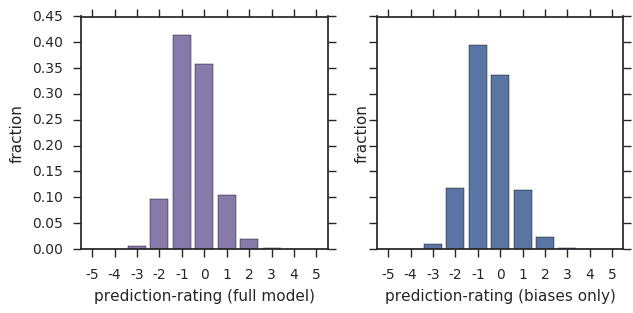

In [58]:
f, axs = plt.subplots(1,2,sharey=True, figsize=(7,3))
plt.sca(axs[0])
utils.plot_histogram(bins1, count1, "prediction-rating (full model)", color=utils.purple)
plt.sca(axs[1])
utils.plot_histogram(bins2, count2, "prediction-rating (biases only)", color=utils.blue)
plt.savefig("plots/movielens_histogram_pred_error.pdf", bbox_inches="tight")

## Untersuchung der Vektoren $Q$ und $P$

In [59]:
vector_lengths_user = als.itemFactors.rdd.map(lambda r: np.sqrt(np.dot(r[1],r[1]))).collect()
vector_lengths_item = als.userFactors.rdd.map(lambda r: np.sqrt(np.dot(r[1],r[1]))).collect()

### Verteilung der Längen der Vektoren

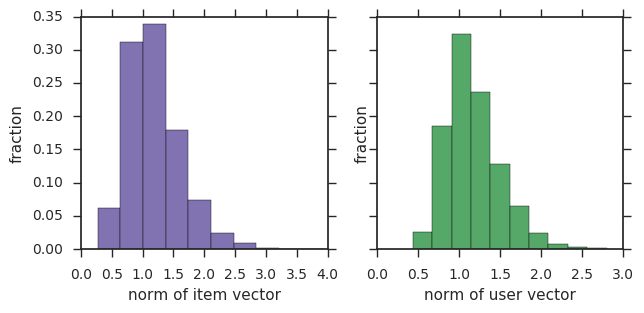

In [60]:
f, axs = plt.subplots(1,2,sharey=True, figsize=(7,3))
plt.sca(axs[0])
counts, bins = plt.histogram(vector_lengths_item)
utils.plot_histogram(bins, counts, "norm of item vector", seaborn=False, color=utils.purple)
plt.sca(axs[1])
counts, bins = plt.histogram(vector_lengths_user)
utils.plot_histogram(bins, counts, "norm of user vector", seaborn=False, color=utils.green)

## Gesamte Laufzeit des Notebooks

In [61]:
print("{:.1f} hours".format((time.time() - start_time)/3600))

0.6 hours


Das Notebook wurde auf einem VPS von Digital Ocean ausgeführt, dieser hat 8 (virtuelle) Cores und 16 GB RAM.